In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4060


In [2]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, cv2
from pathlib import Path
from tqdm import tqdm

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torchvision import models
from torchvision.models import ResNet18_Weights

In [3]:
from time import sleep
for _ in tqdm(range(100)):
    sleep(0.02)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.09it/s]


In [4]:
# ---------------------------- CONFIG (edit if needed) ----------------------------
ROOT        = r"C:\Users\User\Downloads\Dataset_2"      # train/val/test live here
SAVE_DIR    = r"C:\Users\User\Downloads\Dataset\ckpts_hybrid"
MODEL_EFF   = "efficientnet_b3"       # if OOM: 'efficientnet_b0' and set IMG_SIZE=224
IMG_SIZE    = 300                     # 224 for b0; 300 for b3
BATCH_SIZE  = 16
EPOCHS      = 35
FREEZE_EPOCHS = 5                     # freeze backbones for first N epochs
LR          = 3e-4
LABEL_SMOOTH= 0.1
NUM_WORKERS = 0                       # safest on Windows; try 2 later
USE_SAMPLER = True
EARLY_STOP  = 8                       # patience
TTA_FLIP    = True

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def seed_all(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.benchmark = True
seed_all(42)

Device: cuda


In [5]:
try:
    from torch import amp
    def amp_autocast(): return amp.autocast(device_type='cuda', enabled=torch.cuda.is_available())
    scaler = amp.GradScaler(device='cuda', enabled=torch.cuda.is_available())
except Exception:
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
    def amp_autocast(): return _autocast(enabled=torch.cuda.is_available())
    scaler = _GradScaler(enabled=torch.cuda.is_available())

In [8]:
# ---------------------------- DATA: folder → DataFrame ----------------------------
def make_df(split):
    base = Path(ROOT)/split
    classes = sorted([p.name for p in base.iterdir() if p.is_dir()])

    paths, labels = [], []
    for idx, cname in enumerate(classes):
        for fp in (base/cname).iterdir():
            if fp.is_file():
                paths.append(str(fp)); labels.append(idx)
    df = pd.DataFrame({"image_path": paths, "label": labels})
    print(f"[{split}] counts:", df["label"].value_counts().sort_index().to_dict())
    return df, classes

train_df, class_names = make_df("train")
val_df,   _           = make_df("val")
test_df,  _           = make_df("test")
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

[train] counts: {0: 503, 1: 488, 2: 232, 3: 221, 4: 206}
[val] counts: {0: 503, 1: 488, 2: 232, 3: 221, 4: 206}
[test] counts: {0: 503, 1: 488, 2: 232, 3: 221, 4: 206}
Classes: ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


In [9]:
# ---------------------------- TRANSFORMS (Albumentations 1.4.x) ----------------------------
train_tfms = A.Compose([
    A.Resize(int(IMG_SIZE*1.15), int(IMG_SIZE*1.15)),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15), rotate=(-15, 15), translate_percent=(0.05, 0.05),
        interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, p=0.7
    ),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.Normalize(),
    ToTensorV2(),
])
eval_tfms = A.Compose([
    A.Resize(int(IMG_SIZE*1.15), int(IMG_SIZE*1.15)),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2(),
])

class ImgDS(Dataset):
    def __init__(self, df, tfm): self.df=df.reset_index(drop=True); self.tfm=tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        p = self.df.loc[i,"image_path"]; y = int(self.df.loc[i,"label"])
        img = cv2.imread(p)
        if img is None: raise FileNotFoundError(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.tfm(image=img)["image"]
        return img, y

train_ds, val_ds, test_ds = ImgDS(train_df,train_tfms), ImgDS(val_df,eval_tfms), ImgDS(test_df,eval_tfms)

sampler = None
if USE_SAMPLER:
    cnt = train_df['label'].value_counts()
    w_map = {k: 1.0/max(v,1) for k,v in cnt.items()}
    weights = train_df['label'].map(lambda y: float(w_map[int(y)])).values
    sampler = WeightedRandomSampler(torch.from_numpy(weights).double(), len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(sampler is None),
                          sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
# ---------------------------- HYBRID MODEL (ResNet18 + EffNetB3) ----------------------------
class ResEffiNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, eff_name=MODEL_EFF, eff_pretrained=True, res_pretrained=True):
        super().__init__()
        # EfficientNet backbone with pooled features
        self.eff = timm.create_model(eff_name, pretrained=eff_pretrained, num_classes=0, global_pool='avg')
        eff_dim = self.eff.num_features

        # ResNet18 backbone with pooled features
        res = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if res_pretrained else None)
        res.fc = nn.Identity()                  # keep avgpool + flatten inside forward
        self.res = res
        res_dim = res.fc.in_features if hasattr(res.fc, "in_features") else 512  # fallback

        fused_dim = eff_dim + res_dim

        # fusion head (light MLP)
        self.head = nn.Sequential(
            nn.BatchNorm1d(fused_dim),
            nn.Dropout(0.5),
            nn.Linear(fused_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def extract_feats(self, x):
        fe = self.eff(x)          # [B, eff_dim]
        fr = self.res(x)          # [B, res_dim] because fc=Identity keeps pooled vector
        return fe, fr

    def forward(self, x):
        fe, fr = self.extract_feats(x)
        f = torch.cat([fe, fr], dim=1)
        return self.head(f)

    def freeze_backbones(self, freeze=True):
        for m in [self.eff, self.res]:
            for p in m.parameters(): p.requires_grad = not freeze

In [11]:
# ---------------------------- TRAIN / EVAL UTILS ----------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

def train_one_epoch(model, loader, opt):
    model.train()
    run_loss, corr, tot = 0.0, 0, 0
    pbar = tqdm(loader, desc="train")
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with amp_autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()

        run_loss += loss.item()*x.size(0)
        corr += (logits.argmax(1)==y).sum().item(); tot += y.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{corr/max(1,tot)*100:.2f}%")
    return run_loss/max(1,tot), corr/max(1,tot)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum, corr, tot = 0.0, 0, 0
    with amp_autocast():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item()*x.size(0)
            corr += (logits.argmax(1)==y).sum().item(); tot += y.size(0)
    return loss_sum/max(1,tot), corr/max(1,tot)

In [12]:
# --- put near your other hyperparams ---
MIN_EPOCHS = 40                 # << require at least 50 epochs
EPOCHS = max(EPOCHS, MIN_EPOCHS)  # safeguard in case EPOCHS < 50

In [13]:
# ---------------------------- TRAIN THE HYBRID ----------------------------
model = ResEffiNet(NUM_CLASSES).to(device)
opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

BEST = str(Path(SAVE_DIR)/"best_hybrid_reseffinet.pt")
hist = {"epoch":[], "tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[]}
best_acc = 0.0
patience_left = EARLY_STOP if EARLY_STOP > 0 else 10**9

for ep in range(1, EPOCHS + 1):
    # freeze/unfreeze schedule
    if ep <= FREEZE_EPOCHS:
        model.freeze_backbones(True)
    elif ep == FREEZE_EPOCHS + 1:
        model.freeze_backbones(False)

    tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
    va_loss, va_acc = evaluate(model, val_loader)
    sched.step()

    hist["epoch"].append(ep)
    hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc)
    hist["va_loss"].append(va_loss); hist["va_acc"].append(va_acc)
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"model": model.state_dict(), "acc": va_acc, "classes": class_names}, BEST)
        patience_left = EARLY_STOP if EARLY_STOP > 0 else patience_left
        print("  ✅ saved:", BEST)
    else:
        # Do not early-stop before MIN_EPOCHS
        if ep >= MIN_EPOCHS and EARLY_STOP > 0:
            patience_left -= 1
            print(f"  no improvement | patience left: {patience_left}")
            if patience_left <= 0:
                print(f"Early stopping after {ep} epochs (min {MIN_EPOCHS} satisfied).")
                break
        else:
            # Before MIN_EPOCHS, we keep training and do not count down patience.
            pass


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:19<00:00,  5.24it/s, acc=48.18%, loss=0.5982]


Epoch 01 | train 1.3847/0.4818 | val nan/0.6624
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:11<00:00,  9.22it/s, acc=57.70%, loss=0.9093]


Epoch 02 | train 1.2177/0.5770 | val nan/0.6691
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:09<00:00, 11.18it/s, acc=59.64%, loss=0.8498]


Epoch 03 | train 1.1642/0.5964 | val nan/0.7212
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 11.73it/s, acc=61.76%, loss=1.4751]


Epoch 04 | train 1.1110/0.6176 | val nan/0.7176


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:08<00:00, 12.11it/s, acc=62.24%, loss=1.5009]


Epoch 05 | train 1.0985/0.6224 | val nan/0.7448
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:26<00:00,  3.94it/s, acc=64.12%, loss=2.4833]


Epoch 06 | train 1.1023/0.6412 | val nan/0.7194


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.61it/s, acc=75.64%, loss=0.6147]


Epoch 07 | train 0.9177/0.7564 | val nan/0.8412
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.71it/s, acc=78.73%, loss=0.6917]


Epoch 08 | train 0.8370/0.7873 | val nan/0.8806
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.63it/s, acc=83.70%, loss=0.7703]


Epoch 09 | train 0.7598/0.8370 | val 0.7577/0.8661


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.67it/s, acc=85.64%, loss=1.3209]


Epoch 10 | train 0.7035/0.8564 | val 0.8091/0.8345


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.76it/s, acc=87.03%, loss=0.4953]


Epoch 11 | train 0.6829/0.8703 | val 0.5779/0.9152
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=90.30%, loss=1.8870]


Epoch 12 | train 0.6148/0.9030 | val 0.6112/0.9073


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.59it/s, acc=91.45%, loss=1.4428]


Epoch 13 | train 0.5997/0.9145 | val 0.5555/0.9364
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=92.18%, loss=0.4701]


Epoch 14 | train 0.5782/0.9218 | val 0.5150/0.9406
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=92.06%, loss=0.7430]


Epoch 15 | train 0.5732/0.9206 | val nan/0.9612
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.61it/s, acc=93.21%, loss=0.6150]


Epoch 16 | train 0.5457/0.9321 | val 0.5131/0.9455


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.73it/s, acc=94.18%, loss=0.7279]


Epoch 17 | train 0.5409/0.9418 | val nan/0.9552


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.66it/s, acc=94.18%, loss=2.8306]


Epoch 18 | train 0.5413/0.9418 | val 0.4676/0.9667
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.67it/s, acc=95.82%, loss=0.7950]


Epoch 19 | train 0.5119/0.9582 | val 0.4915/0.9588


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=96.06%, loss=0.4337]


Epoch 20 | train 0.5017/0.9606 | val 0.4569/0.9745
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.68it/s, acc=95.64%, loss=0.9484]


Epoch 21 | train 0.5110/0.9564 | val 0.4408/0.9788
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.67it/s, acc=96.30%, loss=0.5666]


Epoch 22 | train 0.4936/0.9630 | val 0.4485/0.9752


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=96.36%, loss=0.6991]


Epoch 23 | train 0.4854/0.9636 | val 0.4447/0.9812
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.67it/s, acc=96.00%, loss=0.5713]


Epoch 24 | train 0.4850/0.9600 | val 0.4493/0.9788


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.66it/s, acc=97.15%, loss=2.7685]


Epoch 25 | train 0.4771/0.9715 | val 0.4434/0.9770


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=97.33%, loss=0.4461]


Epoch 26 | train 0.4668/0.9733 | val 0.4351/0.9836
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=96.97%, loss=0.4607]


Epoch 27 | train 0.4709/0.9697 | val 0.4279/0.9855
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.65it/s, acc=97.33%, loss=0.6947]


Epoch 28 | train 0.4656/0.9733 | val 0.4297/0.9879
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.78it/s, acc=98.12%, loss=0.5639]


Epoch 29 | train 0.4497/0.9812 | val 0.4285/0.9867


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.66it/s, acc=98.12%, loss=0.4768]


Epoch 30 | train 0.4448/0.9812 | val 0.4449/0.9848


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.53it/s, acc=98.06%, loss=0.4638]


Epoch 31 | train 0.4510/0.9806 | val 0.4447/0.9800


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.51it/s, acc=98.61%, loss=0.8445]


Epoch 32 | train 0.4434/0.9861 | val 0.4332/0.9818


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.67it/s, acc=98.79%, loss=0.4623]


Epoch 33 | train 0.4365/0.9879 | val 0.4399/0.9782


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.79it/s, acc=98.36%, loss=0.4518]


Epoch 34 | train 0.4425/0.9836 | val 0.4316/0.9848


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.78it/s, acc=98.79%, loss=2.1969]


Epoch 35 | train 0.4353/0.9879 | val 0.4224/0.9873


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.79it/s, acc=98.30%, loss=0.4399]


Epoch 36 | train 0.4403/0.9830 | val 0.4234/0.9897
  ✅ saved: C:\Users\User\Downloads\Dataset\ckpts_hybrid\best_hybrid_reseffinet.pt


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.81it/s, acc=98.42%, loss=0.4727]


Epoch 37 | train 0.4473/0.9842 | val 0.4281/0.9855


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.76it/s, acc=98.30%, loss=0.4600]


Epoch 38 | train 0.4414/0.9830 | val 0.4422/0.9830


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:17<00:00,  5.83it/s, acc=98.42%, loss=0.5478]


Epoch 39 | train 0.4411/0.9842 | val 0.4432/0.9879


train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:18<00:00,  5.77it/s, acc=98.42%, loss=0.4909]


Epoch 40 | train 0.4404/0.9842 | val 0.4217/0.9897
  no improvement | patience left: 7


In [14]:
# ---------------------------- LOAD BEST & TEST (with TTA) ----------------------------
ckpt = torch.load(BEST, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

@torch.no_grad()
def predict_probs(m, loader, tta=TTA_FLIP):
    m.eval(); out=[]; y_true=[]
    with amp_autocast():
        for x,y in tqdm(loader, desc="test"):
            y_true.extend(y.numpy().tolist())
            x = x.to(device)
            p = torch.softmax(m(x),1)
            if tta:
                pf = torch.softmax(m(torch.flip(x, dims=[3])),1)
                p = (p+pf)/2
            out.append(p.cpu().numpy())
    return np.concatenate(out,0), np.array(y_true)

probs_test, y_true = predict_probs(model, test_loader)
preds = probs_test.argmax(1)
acc = (preds==y_true).mean()
print(f"\nHYBRID TEST ACCURACY: {acc:.4f}\n")
print(classification_report(y_true, preds, target_names=class_names, digits=4))

C:\Users\User\AppData\Local\Temp\ipykernel_12680\4174582418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST, map_location=device)
test: 100%|█████


HYBRID TEST ACCURACY: 0.9921

              precision    recall  f1-score   support

     0Normal     0.9921    0.9960    0.9940       503
   1Doubtful     0.9938    0.9857    0.9897       488
       2Mild     0.9913    0.9828    0.9870       232
   3Moderate     0.9866    1.0000    0.9933       221
     4Severe     0.9952    1.0000    0.9976       206

    accuracy                         0.9921      1650
   macro avg     0.9918    0.9929    0.9923      1650
weighted avg     0.9921    0.9921    0.9921      1650



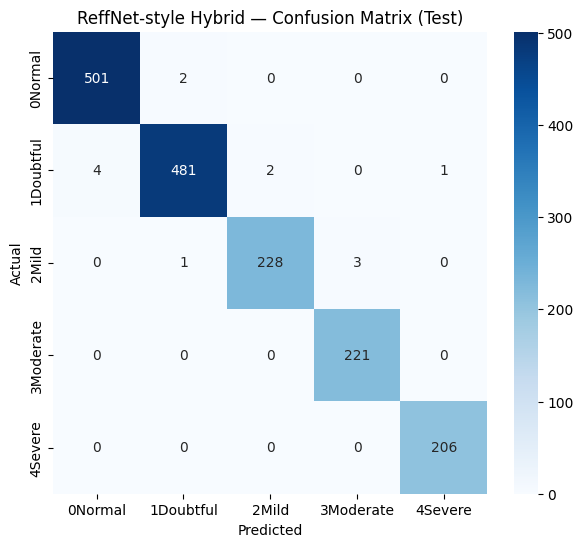

In [15]:
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("ReffNet-style Hybrid — Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


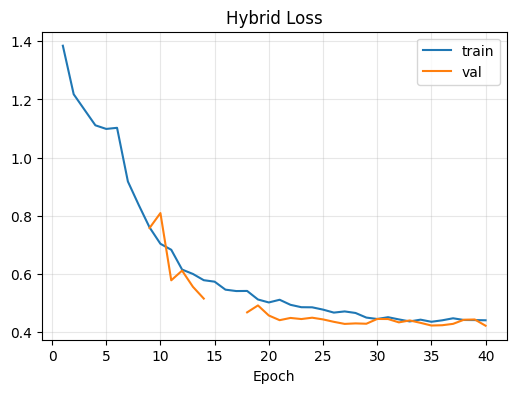

In [16]:
ep = np.array(hist["epoch"])
plt.figure(figsize=(6,4)); plt.plot(ep, hist["tr_loss"], label="train"); plt.plot(ep, hist["va_loss"], label="val")
plt.title("Hybrid Loss"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

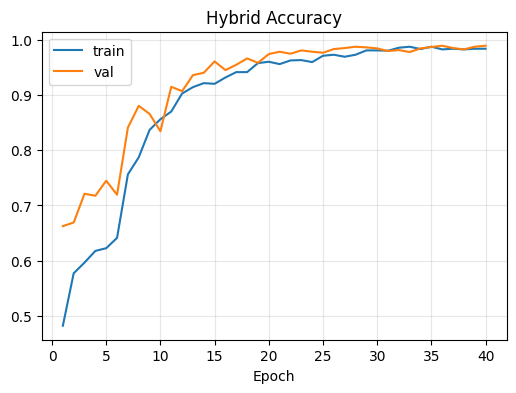

In [17]:
plt.figure(figsize=(6,4)); plt.plot(ep, hist["tr_acc"], label="train"); plt.plot(ep, hist["va_acc"], label="val")
plt.title("Hybrid Accuracy"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

In [18]:
# --- CLASSIFICATION METRICS (per-class P, R, F1, AP and macro averages) ---
import numpy as np, pandas as pd, torch
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

model.eval()
all_probs, all_preds, all_true = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs  = torch.softmax(logits, dim=1)
        pred   = probs.argmax(1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_preds)
y_prob = np.concatenate(all_probs)   # shape [N, C]

# per-class precision/recall/F1
P, R, F1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
)

# per-class (classification) AP = PR-AUC (one-vs-rest)
ap_per_class = []
for c in range(len(class_names)):
    y_true_bin = (y_true == c).astype(int)
    ap = average_precision_score(y_true_bin, y_prob[:, c]) if y_true_bin.sum() > 0 else 0.0
    ap_per_class.append(ap)

df_cls = pd.DataFrame({
    "Class": class_names,
    "Instances": support,
    "P": np.round(P, 2),
    "R": np.round(R, 2),
    "F1": np.round(F1, 2),
    "AP (PR-AUC)": np.round(ap_per_class, 2)
})

# macro averages
macro = pd.DataFrame([{
    "Class": "macro-avg",
    "Instances": int(np.sum(support)),
    "P": np.round(np.mean(P), 2),
    "R": np.round(np.mean(R), 2),
    "F1": np.round(np.mean(F1), 2),
    "AP (PR-AUC)": np.round(np.mean(ap_per_class), 2)
}])

print(pd.concat([df_cls, macro], ignore_index=True))


       Class  Instances     P     R    F1  AP (PR-AUC)
0    0Normal        503  0.99  0.99  0.99         0.99
1  1Doubtful        488  0.99  0.98  0.98         1.00
2      2Mild        232  0.98  0.99  0.98         0.99
3  3Moderate        221  0.99  1.00  1.00         1.00
4    4Severe        206  0.99  1.00  1.00         1.00
5  macro-avg       1650  0.99  0.99  0.99         1.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1585186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6639651].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.621286..1.8382571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059..1.8033987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.4896731].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7

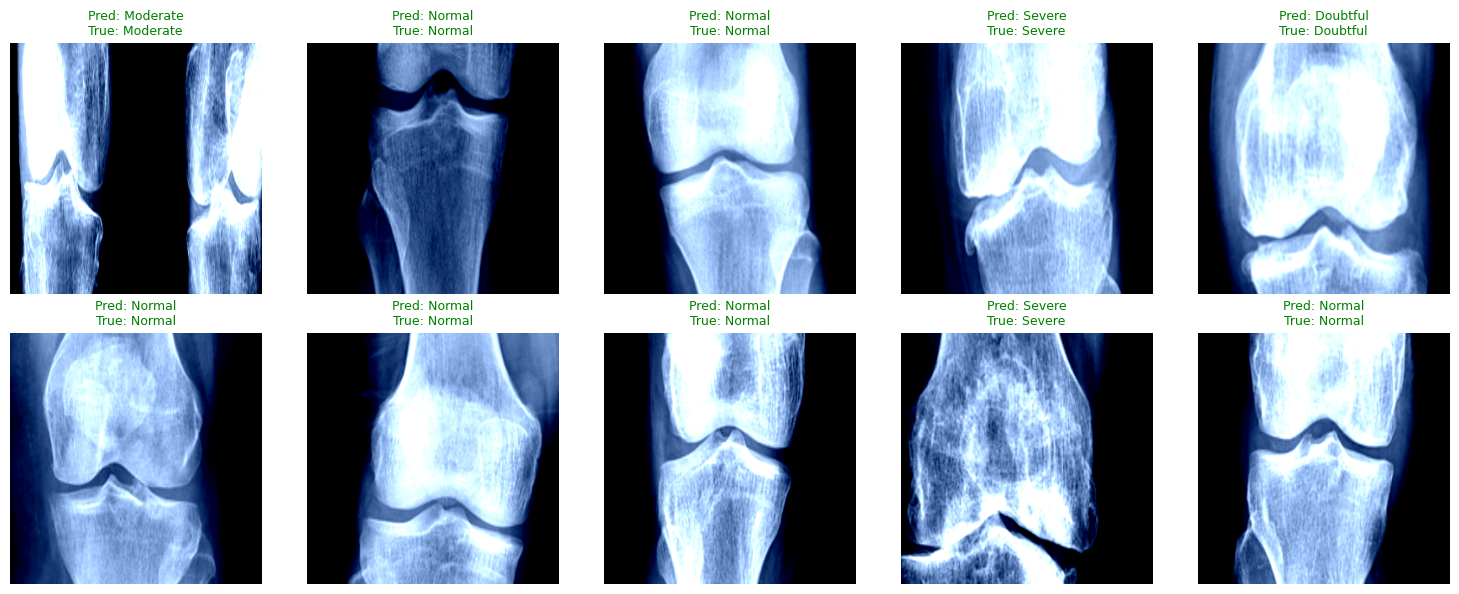

In [19]:
import matplotlib.pyplot as plt
import random

# Define class names (in correct order used during training)
class_names = ["Normal", "Doubtful", "Mild", "Moderate", "Severe"]

# Put model in eval mode
model.eval()

# Pick N random test samples
N = 10
examples = random.sample(range(len(test_loader.dataset)), N)

fig, axes = plt.subplots(2, N//2, figsize=(15, 6))

with torch.no_grad():
    for i, idx in enumerate(examples):
        # get image + label
        img, label = test_loader.dataset[idx]
        img_in = img.unsqueeze(0).to(device)

        # forward pass
        logits = model(img_in)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred = probs.argmax()

        # show image
        ax = axes[i//(N//2), i%(N//2)]
        ax.imshow(img.permute(1, 2, 0))  # convert CHW->HWC
        ax.axis("off")

        # title: Predicted + True
        ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}",
                     color=("green" if pred==label else "red"), fontsize=9)

plt.tight_layout()
plt.show()


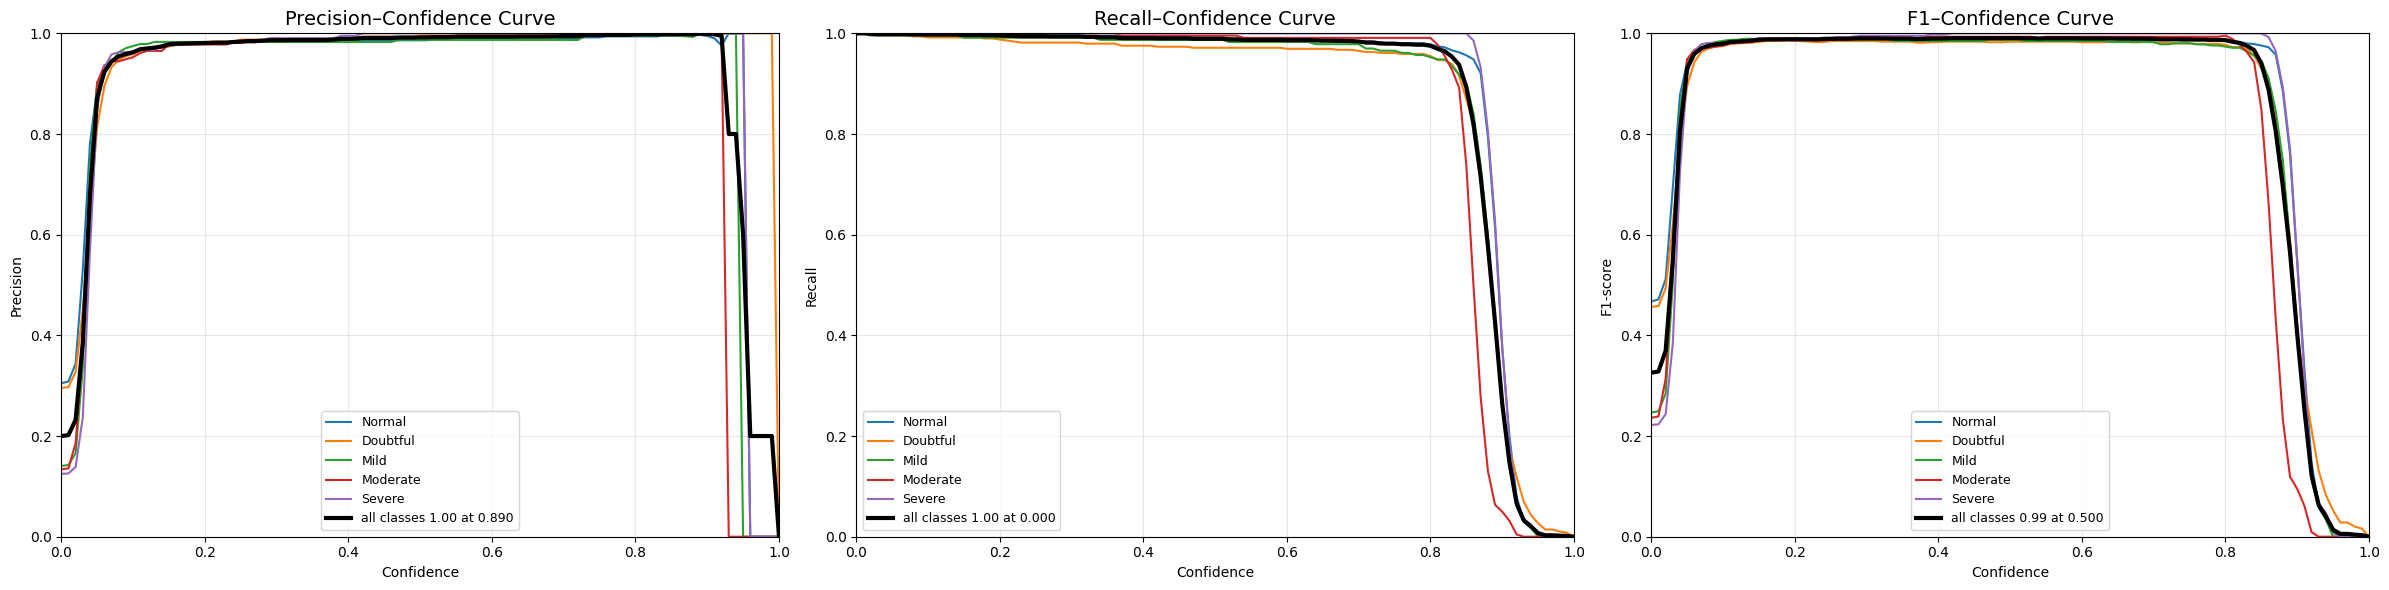

In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Collect model outputs ---
model.eval()
probs_all, labels_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        probs_all.append(torch.softmax(logits, dim=1).cpu().numpy())
        labels_all.append(yb.numpy())
y_prob = np.concatenate(probs_all, 0)   # [N, C]
y_true = np.concatenate(labels_all, 0)  # [N]
num_classes = len(class_names)

# --- Thresholds ---
thresholds = np.linspace(0, 1, 101)

# --- Storage: [C, T] ---
prec_curves = np.zeros((num_classes, len(thresholds)))
rec_curves  = np.zeros((num_classes, len(thresholds)))
f1_curves   = np.zeros((num_classes, len(thresholds)))

def prf_at_thresh(y_true, y_scores, thr):
    pred_pos = (y_scores >= thr)
    true_pos = (y_true == 1)
    TP = np.sum(pred_pos & true_pos)
    FP = np.sum(pred_pos & ~true_pos)
    FN = np.sum(~pred_pos & true_pos)
    P = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    R = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = (2 * P * R / (P + R)) if (P + R) > 0 else 0.0
    return P, R, F1

# --- Compute curves per class ---
for c in range(num_classes):
    y_true_bin = (y_true == c).astype(int)
    scores_c = y_prob[:, c]
    for ti, thr in enumerate(thresholds):
        P, R, F1 = prf_at_thresh(y_true_bin, scores_c, thr)
        prec_curves[c, ti] = P
        rec_curves[c, ti]  = R
        f1_curves[c, ti]   = F1

# Macro averages
prec_macro = np.nanmean(prec_curves, axis=0)
rec_macro  = np.nanmean(rec_curves,  axis=0)
f1_macro   = np.nanmean(f1_curves,   axis=0)
best_idx   = np.argmax(f1_macro)

# --- Plotting all curves ---
fig, axs = plt.subplots(1, 3, figsize=(24, 6))


# (a) Precision–Confidence
for c in range(num_classes):
    axs[0].plot(thresholds, prec_curves[c], lw=1.5, label=class_names[c])
axs[0].plot(thresholds, prec_macro, lw=3, color="black",
            label=f"all classes {prec_macro.max():.2f} at {thresholds[np.argmax(prec_macro)]:.3f}")
axs[0].set_title("Precision–Confidence Curve", fontsize=14)
axs[0].set_xlabel("Confidence"); axs[0].set_ylabel("Precision")
axs[0].set_xlim(0,1); axs[0].set_ylim(0,1); axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=9)

# (b) Recall–Confidence
for c in range(num_classes):
    axs[1].plot(thresholds, rec_curves[c], lw=1.5, label=class_names[c])
axs[1].plot(thresholds, rec_macro, lw=3, color="black",
            label=f"all classes {rec_macro.max():.2f} at {thresholds[np.argmax(rec_macro)]:.3f}")
axs[1].set_title("Recall–Confidence Curve", fontsize=14)
axs[1].set_xlabel("Confidence"); axs[1].set_ylabel("Recall")
axs[1].set_xlim(0,1); axs[1].set_ylim(0,1); axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=9)

# (c) F1–Confidence
for c in range(num_classes):
    axs[2].plot(thresholds, f1_curves[c], lw=1.5, label=class_names[c])
axs[2].plot(thresholds, f1_macro, lw=3, color="black",
            label=f"all classes {f1_macro[best_idx]:.2f} at {thresholds[best_idx]:.3f}")
axs[2].set_title("F1–Confidence Curve", fontsize=14)
axs[2].set_xlabel("Confidence"); axs[2].set_ylabel("F1-score")
axs[2].set_xlim(0,1); axs[2].set_ylim(0,1); axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=9)

plt.tight_layout()
plt.show()

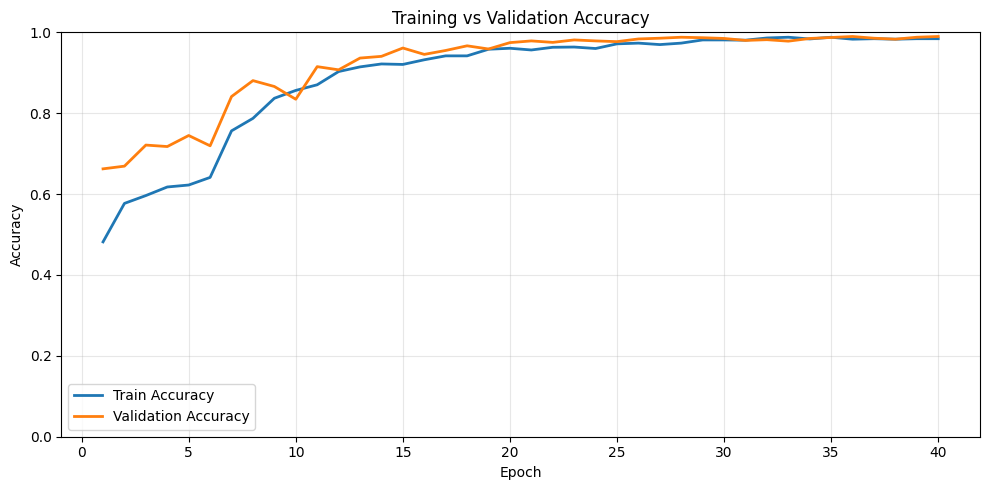

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(hist["epoch"], hist["tr_acc"], label="Train Accuracy", linewidth=2)
plt.plot(hist["epoch"], hist["va_acc"], label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0,1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
